In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

%matplotlib inline
rcParams['figure.figsize'] = 9, 6

# Generate Imbalanced Datasets

In [3]:
# make 3-class dataset for classification
center1 = [[0, 0]]
X1, y1 = make_blobs(n_samples=800, centers=center1, random_state=42)
center2 = [[0, 0], [1, 1]]
X2, y2 = make_blobs(n_samples=200,
                    centers=center2,
                    random_state=42,
                    cluster_std=0.3)
X = np.vstack((X1, X2))
y = np.hstack((y1, y2))

* 在圖上紅色點表示為壞人(1)，藍色點是好人(0)
* 今天身為一位警察該如何透過兩個 feature 從好人中去抓出壞人呢？
* 這邊產生的資料只有 20% 是壞人，80% 是好人

Text(0, 0.5, 'Feature2')

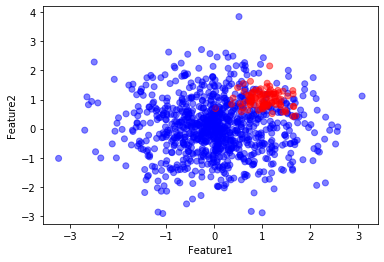

In [4]:
color = "br"
color = [color[y[i]] for i in range(len(y))]
plt.scatter(X[:, 0], X[:, 1], c=color, alpha=.5)
plt.xlabel('Feature1')
plt.ylabel('Feature2')

# Predict with Logistic Regression

Accuracy:0.88


Text(0, 0.5, 'Feature2')

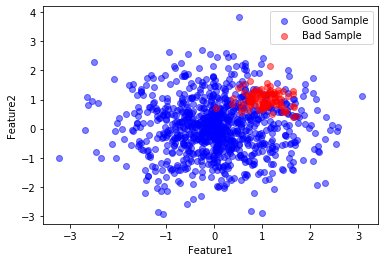

In [5]:
model = LogisticRegression()
model.fit(X, y)
prediction = model.predict(X)
print('Accuracy:%.2f' % model.score(X, y))
color = "br"
label = ['Good Sample', 'Bad Sample']
# color = [color[prediction[i]] for i in range(len(y))]
# label = [label[prediction[i]] for i in range(len(y))]
for i in range(2):
    plt.scatter(X[y == i][:, 0],
                X[y == i][:, 1],
                c=color[i],
                label=label[i],
                alpha=.5)
plt.legend()
plt.xlabel('Feature1')
plt.ylabel('Feature2')

# 利用預測機率代替預測結果
* ### 在分類問題中，不管 logistic regression 還是 svm 都是在求解 maxmum likelyhood，因此最後算出來的邊界都是一個軟性邊界（機率分佈）  
### 例如在上面的 logistic regression 模型預測機率如下 model.predict_proba(X) 所示  
### 第一欄代表被預測為 0（好人）的機率，第二欄代表被預測為 1（壞人）的機率。
### 在一般 model.predict() 給出的預測值是直接比較第一欄和第二欄的大小決定的，好人的機率大於壞人的機率，就會預測這筆資料為 0。
### 但是在 imbalanced data 的情況下，我們會去調整 threshold 以達到目的。  
### 假設我們在這個 case 中想要抓出大部分的壞人，那也許我們可以設定被預測為 1 的機率大於 20% 那我們就認定他是壞人，如此的話就可以抓出大部分的壞人，那 20% 就是我們所設定的 threshold。
### 之前有提到一般以 F1_score 來權衡 precision 和 recall，因此在這樣的 case 下我們會去調整 threshold 來求得最大的 F1_score。

In [6]:
print(model.predict_proba(X))

[[0.93888571 0.06111429]
 [0.42284021 0.57715979]
 [0.91550431 0.08449569]
 ...
 [0.59365023 0.40634977]
 [0.64880506 0.35119494]
 [0.98317867 0.01682133]]


In [7]:
print(model.predict_proba(X)[0], '--->', model.predict(X)[0])

[0.93888571 0.06111429] ---> 0


# 定義 function 
# 比較各個不同 threshold 所形成的分類圖。
* ### 這邊主要是要將分類問圖形化給大家看，如果看不懂的話只要知道fucntion的輸入為
    * ### 1. model_type: 可選擇 Logistic 或 SVC
    * ### 2. plot_dict: key 值為設定的 threshold，value 代表的是 subplot 的 index

In [8]:
def auc(model_type, plot_dict):
    model_dict = {
        'Logistic': LogisticRegression(),
        'SVC': SVC(kernel='rbf', probability=True)
    }

    model = model_dict[model_type]
    model.fit(X, y)
    tpr_temp = []
    fpr_temp = []
    precision_temp = []
    recall_temp = []
    f1_score_temp = []
    for threshold in plot_dict:
        # 將預測機率大於 threshold 的分類為 1
        pred = (model.predict_proba(X)[:, 1] >= threshold).astype(int)

        # 先算出 confusion matrix 再算出其他評估值
        cm = confusion_matrix(y, pred)
        tpr = cm[1][1] / cm.sum(axis=1)[1]
        fpr = cm[0][1] / cm.sum(axis=1)[0]
        pre = cm[1][1] / cm.sum(axis=0)[1]  # precision
        re = cm[1][1] / cm.sum(axis=1)[1]  # recall
        f1 = 2 * (pre * re) / (pre + re)  # f1-score

        # 畫圖
        color = "br"
        color = [color[pred[j]] for j in range(len(pred))]
        plt.subplot(plot_dict[threshold])
        plt.tight_layout()
        plt.scatter(X[:, 0], X[:, 1], c=color, alpha=.5)
        plt.title('threshold:%.2f' % threshold + '\n' +
                  'accuracy:%.2f' % accuracy_score(y, pred) + '\n' +
                  'precision:%.2f' % pre + '\n' + 'recall:%.2f' % re + '\n' +
                  'f1-score:%.2f' % f1)

        # 將各種評估值存取成 list 回傳
        tpr_temp.append(tpr)
        fpr_temp.append(fpr)
        precision_temp.append(pre)
        recall_temp.append(re)
        f1_score_temp.append('nan' if f1 != f1 else round(f1, 3))

    return f1_score_temp, tpr_temp, fpr_temp, precision_temp, recall_temp

# Logistic Regression with varied threshold

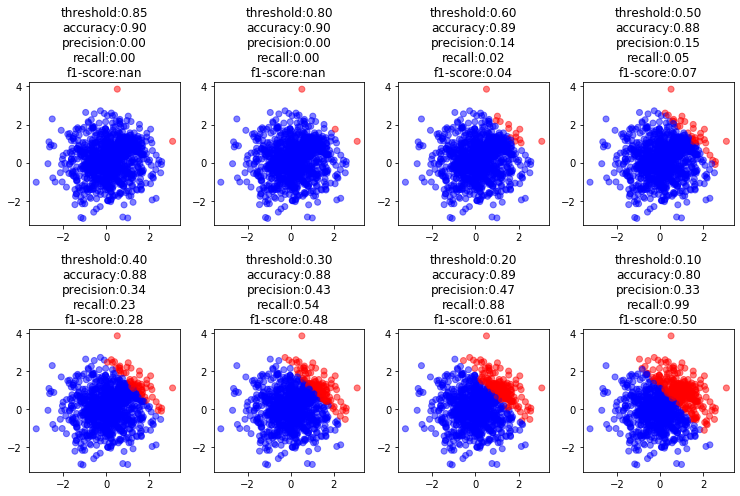

In [9]:
plt.figure(figsize=(10.5, 7))

plot_dict = {
    0.85: 241,
    0.8: 242,
    0.6: 243,
    0.5: 244,
    0.4: 245,
    0.3: 246,
    0.2: 247,
    0.1: 248
}
# 自訂的 function 會回傳不同 threshold 的 f1_score, tpr, fpr, precision 和 recall
f1_0, tpr0, fpr0, precision0, recall0 = auc('Logistic', plot_dict)

#  Precision & Recall & F1_Score
* 圖形化 Precsion Recall curve，並在個點旁邊標出對應的 f1_score 

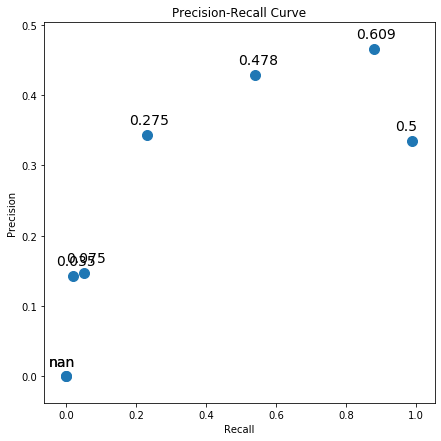

In [10]:
plt.figure(figsize=(7, 7))
plt.scatter(recall0, precision0, s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# Show F1 Score on each point
for i, txt in enumerate(f1_0):
    plt.annotate(txt, (recall0[i] - 0.05, precision0[i] + 0.015), fontsize=14)

plt.show()

# SVM with Varied threshold

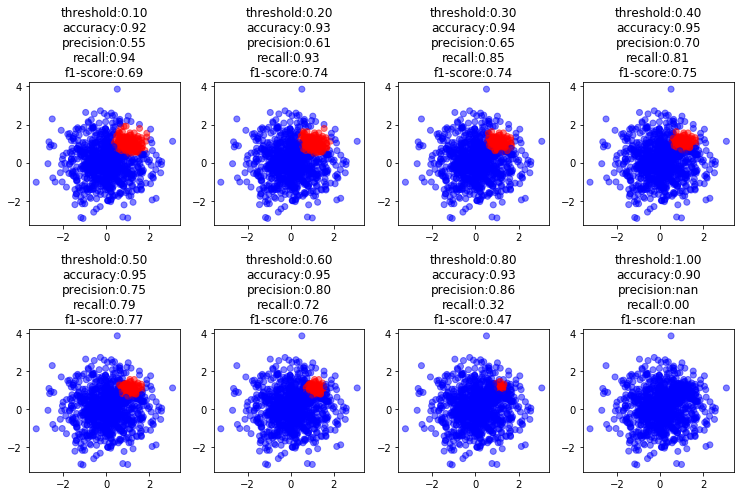

In [11]:
plt.figure(figsize=(10.5, 7))
plot_dict = {
    0.1: 241,
    0.2: 242,
    0.3: 243,
    0.4: 244,
    0.5: 245,
    0.6: 246,
    0.8: 247,
    1: 248
}
f1_1, tpr1, fpr1, precision1, recall1 = auc('SVC', plot_dict)

# Compare Performance between Logistic Regression & SVM
* 比較 logistic regression 和 SVM 的 auc score，大家應該可以清楚地看出來哪個模型在這個問題中表現比較好。

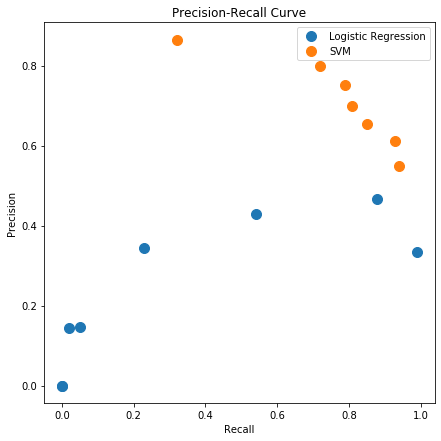

In [12]:
plt.figure(figsize=(7, 7))
plt.plot(recall0, precision0, '.', label='Logistic Regression', markersize=20)
plt.plot(recall1, precision1, '.', label='SVM', markersize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

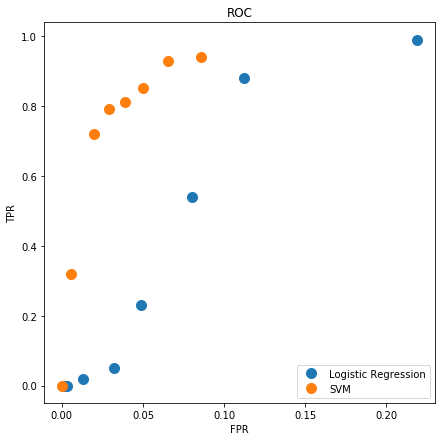

In [13]:
plt.figure(figsize=(7, 7))
plt.plot(fpr0, tpr0, '.', label='Logistic Regression', markersize=20)
plt.plot(fpr1, tpr1, '.', label='SVM', markersize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()

* 有興趣的同學可以查詢 ROC 曲線
* roc curve 底下的面積 AUC 是很常見的一種 evaluation 方式